In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use("seaborn")

import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode , iplot , plot
init_notebook_mode(connected = True)
import cufflinks as cf
cf.go_offline()

import statsmodels.formula.api as smf
import sklearn as sk
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import scipy
from sklearn.ensemble import RandomForestRegressor


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.metrics import r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

import warnings
warnings.filterwarnings('ignore')

# Importing the data

In [3]:
data = pd.read_csv("./data/housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Check the shape of the DataFrame

In [4]:
print('Housing Data - rows:' , data.shape[0],'columns:', data.shape[1])

Housing Data - rows: 20640 columns: 10


# Checking for missing data

In [5]:
print("There is {} missing values in the dataframe".format(data.isnull().sum().sum()))

There is 207 missing values in the dataframe


# What percentage of missing data do we have
# Checking for % of missing values

In [6]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,total_bedrooms,ocean_proximity,median_house_value,median_income,households,population,total_rooms,housing_median_age,latitude,longitude
Total,207.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,1.002907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Total bedrooms has a total of 207 missing data which makes 1% of the entire data so its safe to say we can drop
# the columns or we can replace missing data with mean or median. Usually best to use median as its more robust

# Decision : 
+ I decided to replace all missing values with the median number of the column

# Checking for duplicates

In [7]:
data.duplicated(keep=False).sum()

0

# Observation : 
+ There are no duplicated columns

# Checking the distribution of some columns

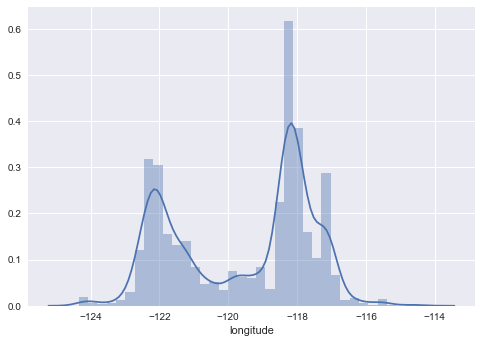

In [8]:
sns.distplot(data['longitude'])
plt.show()

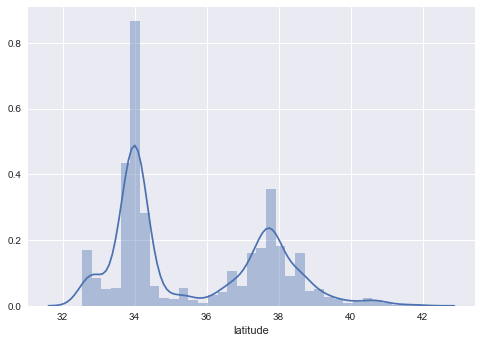

In [9]:
sns.distplot(data['latitude'])
plt.show()

In [10]:
print("latitude min",data["latitude"].min())
print("latitude max value",data["latitude"].max())

print("longitude min", data["longitude"].min())
print("longitude max value",data["longitude"].max())

latitude min 32.54
latitude max value 41.95
longitude min -124.35
longitude max value -114.31


In [ ]:
# Checking the age distribution of the DF

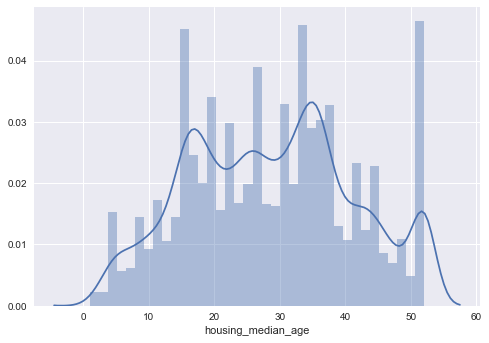

In [11]:
sns.distplot(data['housing_median_age'])
plt.show()

# General observation : 
+ Data is not normally distributed so we will have to normalise the data. However, i am still curious to check the 
  skewnees of the entire dataframe

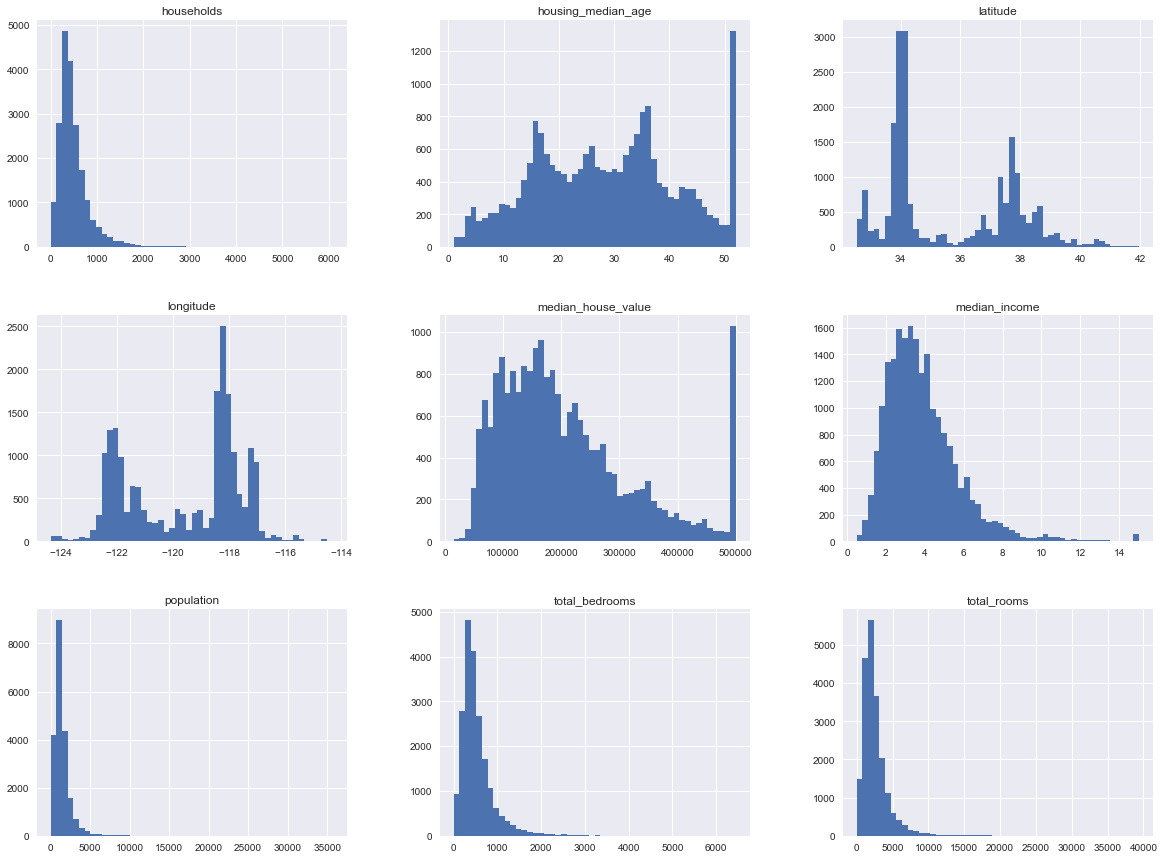

In [12]:
data.hist(bins=50, figsize=(20,15))
# save_fig("attribute_histogram_plots")
plt.show()

# Scatterplot

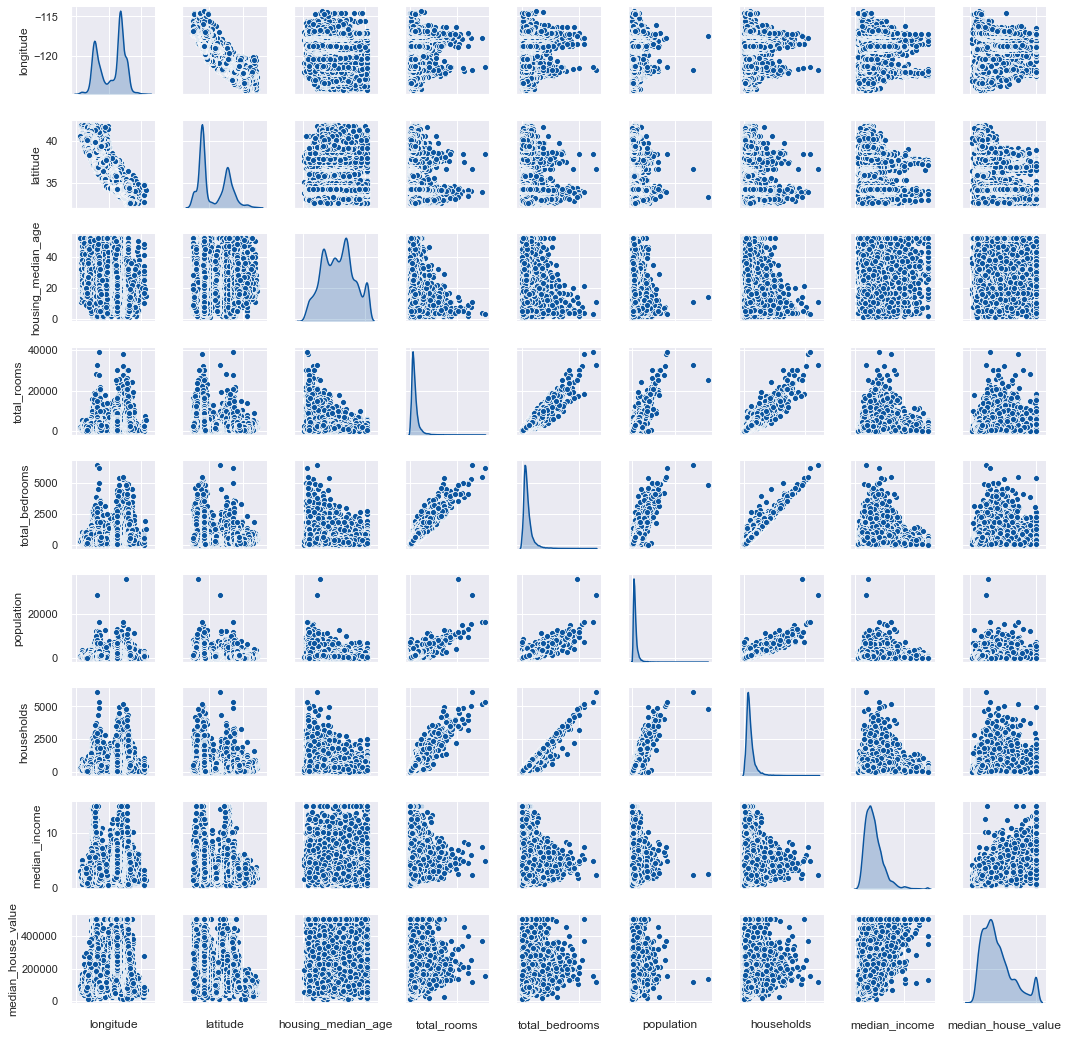

In [21]:
mx_plot = sns.pairplot(data, diag_kind="kde", size=1.6)
mx_plot.set(xticklabels=[])
plt.show()

# Distribution with boxplot and checking the median house value column

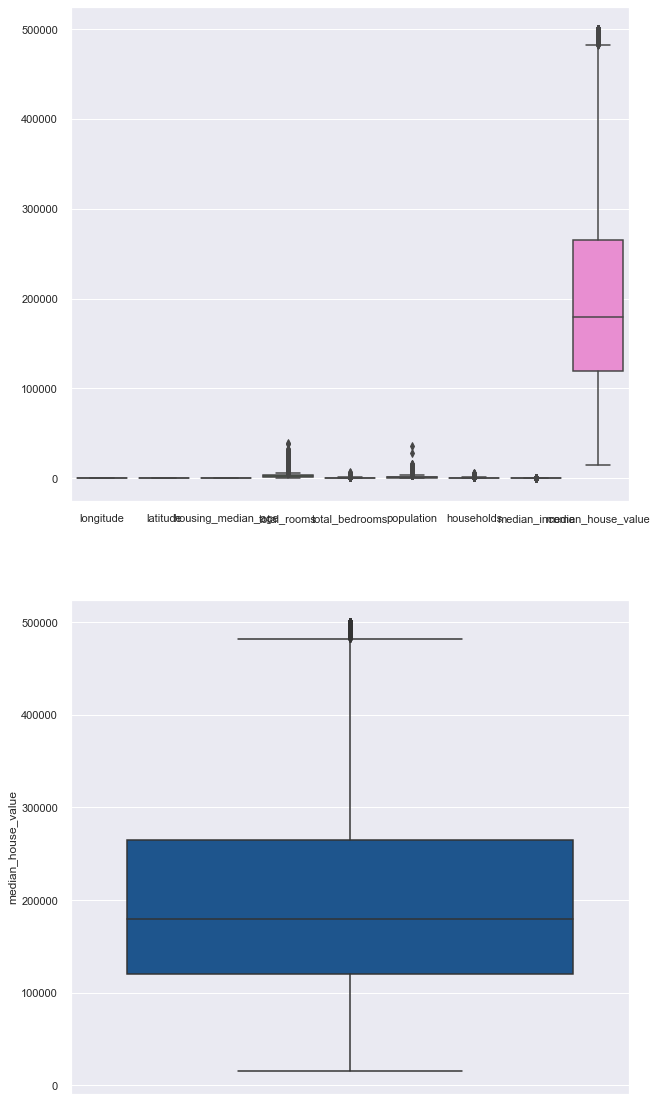

In [16]:
fig, axes = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(10, 20)
sns.boxplot(data=data,orient="v",ax=axes[0])
sns.boxplot(data=data,y="median_house_value",orient="pH",ax=axes[1])
plt.show()                 

# Checking the Proximity of houses to the ocean

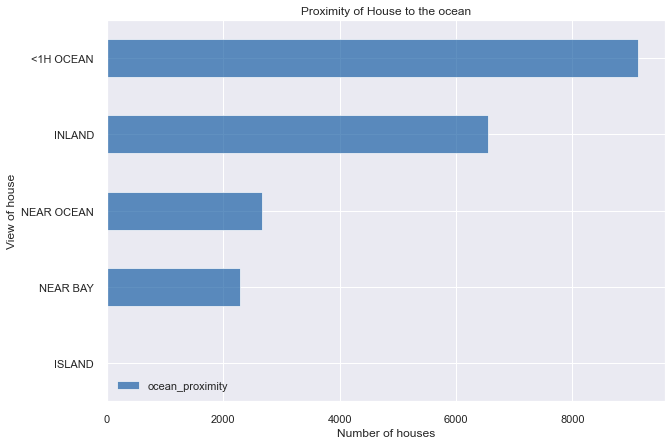

In [13]:
sns.set(palette='Blues_r') 
data.ocean_proximity.value_counts().sort_values(ascending=True).plot(kind='barh',figsize=(10,7),alpha=.65) # color='blue'
plt.legend()
plt.title("Proximity of House to the ocean")
plt.xlabel("Number of houses")
plt.ylabel("View of house")
plt.show()


In [15]:
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

# Correlation analysis

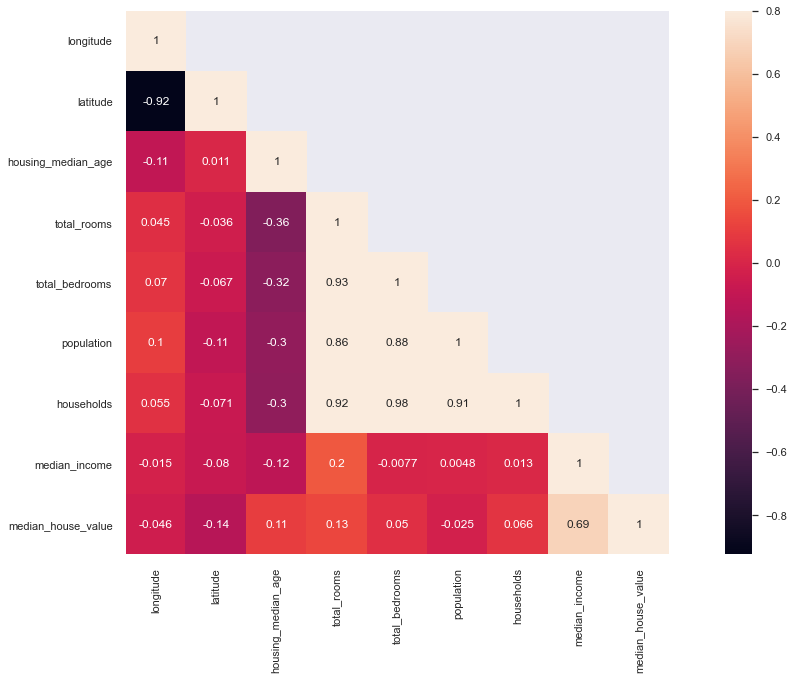

In [22]:
corrMatt = data.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True);

# Heatmap

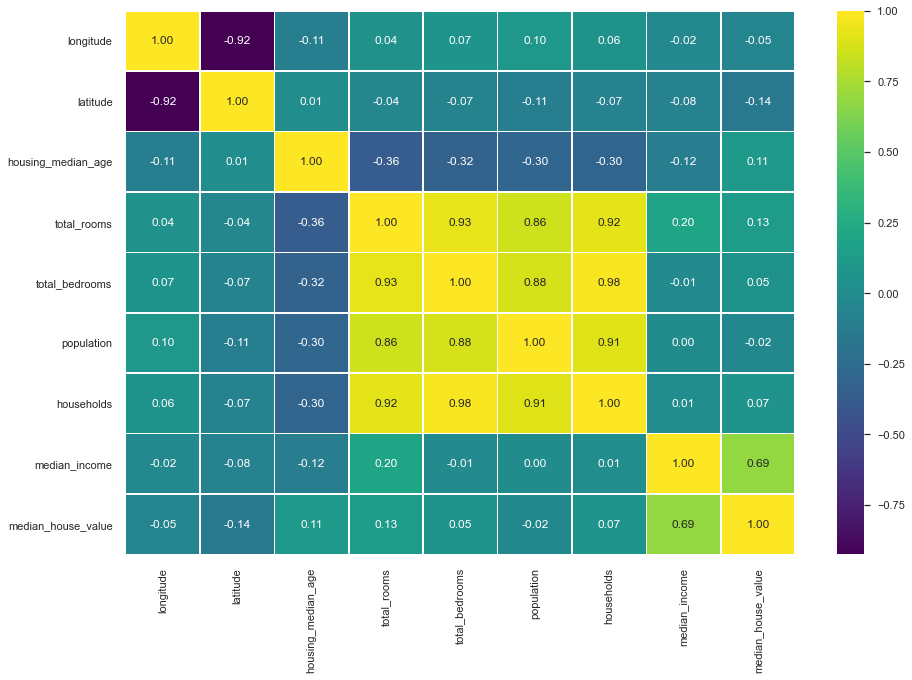

In [23]:
corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt=".2f",
                cmap="viridis");

# Checking distribution of median house value

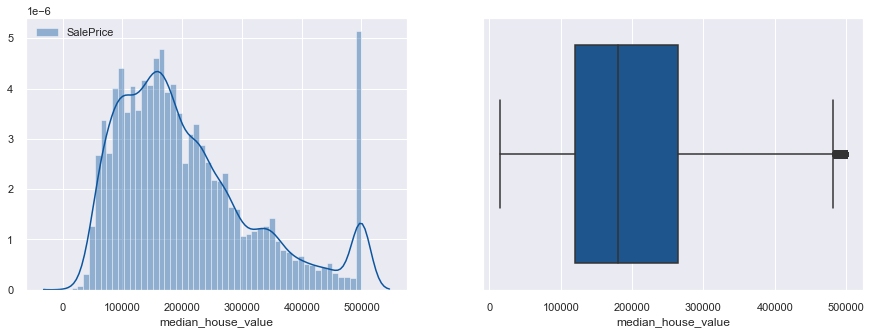

In [24]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(data.median_house_value, bins=50, ax=ax0, label="SalePrice")
ax0.legend()
sns.boxplot(data.median_house_value, ax=ax1)
plt.show();

# Feature engineering

# Checking if data contains strings

In [25]:
for label, content in data.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

ocean_proximity


# Converting strings into categories

In [26]:
for label, content in data.items():
    if pd.api.types.is_string_dtype(content):
        data[label] = content.astype("category").cat.as_ordered()

# Checking the various categories in our Ocean proximity column

In [27]:
data.ocean_proximity.cat.categories

Index(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype='object')

# Taking a look at all the numerical columns

In [28]:
for label, content in data.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

longitude
latitude
housing_median_age
total_rooms
total_bedrooms
population
households
median_income
median_house_value


# Checking for missing numerical variables

In [29]:
for label, content in data.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

total_bedrooms


# Filling in all the missing numerical values

In [30]:
for label, content in data.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            data[label] = pd.isnull(content)
            # fill missing numeric values with median
            data[label] = content.fillna(content.median())

# Checking if there is any null numerical values

In [31]:
for label, content in data.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
        else:
            print(f"There are no missing values in the numerical columns")
        

There are no missing values in the numerical columns
There are no missing values in the numerical columns
There are no missing values in the numerical columns
There are no missing values in the numerical columns
There are no missing values in the numerical columns
There are no missing values in the numerical columns
There are no missing values in the numerical columns
There are no missing values in the numerical columns
There are no missing values in the numerical columns


In [ ]:
# Checking if there are still any missing values

In [33]:
data.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

# Converting the categorical column into numeric

In [34]:
data.ocean_proximity.unique()

[NEAR BAY, <1H OCEAN, INLAND, NEAR OCEAN, ISLAND]
Categories (5, object): [<1H OCEAN < INLAND < ISLAND < NEAR BAY < NEAR OCEAN]

# Creating a custom for loop to convert the column into numerical

In [35]:
ocean_dict = {}
count = 0
for x in data.ocean_proximity.unique():
    ocean_dict[x] = count
    count += 1
ocean_dict  

{'NEAR BAY': 0, '<1H OCEAN': 1, 'INLAND': 2, 'NEAR OCEAN': 3, 'ISLAND': 4}

# Other alternatives :
+ I could have simply created dummy variables for the column
+ Or i could have used the pandas api to convert it. So just so you know there are many other ways to do this
+ However, in case if the categorical columns were a lot, i would have used the pandas api option as i dont have to 
 go through selecting the best features after creating more columns with dummies.

# Mapping the columns to the data

In [36]:
data["ocean_proximity"] = data["ocean_proximity"].map(ocean_dict)

In [ ]:
# Checking the results

In [37]:
data["ocean_proximity"].unique()

[0, 1, 2, 3, 4]
Categories (5, int64): [1 < 2 < 4 < 0 < 3]

# Another way of Converting the categorical column into numerical column

In [ ]:
for label, content in data.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary columns to indicate whether sample had missing value
        data[label] = pd.isnull(content)
        # turn categories into numbers and add + 1
        data[label] = pd.Categorical(content).codes+1

# Checking for numerical columns

In [ ]:
for label, content in data.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

In [63]:
import os
import os
import tarfile
import urllib


# Define the figures saving location
PROJECT_ROOT_DIR = "."   # "D:/AI/SimpliLearn/Lession 3 - Machine Learning/My_Project_Test"
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok = True)


In [73]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://github.com/code-JOA/Housing-Project-Regression/tree/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x129688b00>)

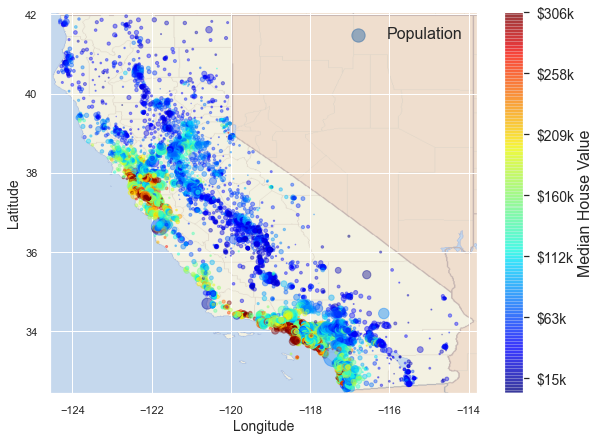

In [74]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = data.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=data['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = data["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show()

In [75]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0


### See these three attributes above? => total_rooms, total_bedrooms, population
- **They are for an entire district. It would be nice to find them for a household. Why?**

- **We are calculating per house price. Correct?**

- **So let’s do that**

- **So basically we are deriving new attributes from existing attributes in our dataset**

In [76]:
data['rooms_per_household'] = data['total_rooms']/data['households']
data['bedrooms_per_room'] = data['total_bedrooms']/data['total_rooms']
data['population_per_household'] = data['population']/data['households']
data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,8.288136,0.129516,2.802260


# Checking the correlation with median house value

# Correlation : 
+ Relationships and dependencies among features
+ Features that are highly correlated with each other should be dropped as per threshold
+ Pearson's correlation :
* Ranges in values from -1.0 to 1.0
* -1 means perfectly opposite or disagreeing 
* 1 means perfectly correlated or agreeing 
* Captures only linear relationships between variables. It wont capture non-linear relationships

In [77]:
corr_matrix = data.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049457
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.233303
Name: median_house_value, dtype: float64

# improving the above code

In [81]:
corr_matrix= data.corr()
corr=corr_matrix.median_house_value.sort_values(ascending=False)
d = pd.DataFrame({'Column':corr.index,
                 'Correlation with median_house_value':corr.values})
d

,Column,Correlation with median_house_value
0,median_house_value,1.000000
1,median_income,0.688075
2,rooms_per_household,0.151948
3,total_rooms,0.134153
4,housing_median_age,0.105623
5,households,0.065843
6,total_bedrooms,0.049457
7,population_per_household,-0.023737
8,population,-0.024650
9,longitude,-0.045967


# Observation :
+ The above shows us which variables are highly correlated to the target, hence median 
  house value in this case.

In [ ]:
# Dealing with the median income column

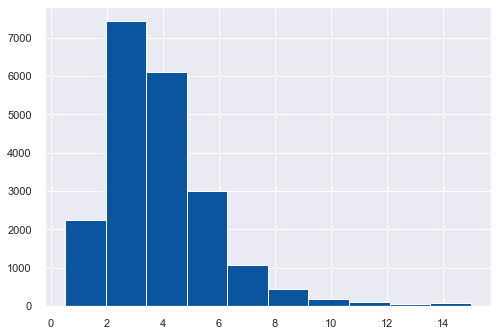

In [85]:
data["median_income"].hist()
plt.show()

# Here i decided to split the column into 6 parts and using a range of 16 so as to capture the whole data. 
+ Why 16? 
* Because if you look at the above visualisation, you can see the last capture is above 14 so 16 will be perfect.

In [87]:
buckets = np.linspace(0,16,6)
data["median_income_cats"] = pd.cut(data["median_income"], buckets)

In [88]:
data["median_income_cats"].value_counts()

(3.2, 6.4]      10232
(0.0, 3.2]       8659
(6.4, 9.6]       1407
(9.6, 12.8]       256
(12.8, 16.0]       86
Name: median_income_cats, dtype: int64

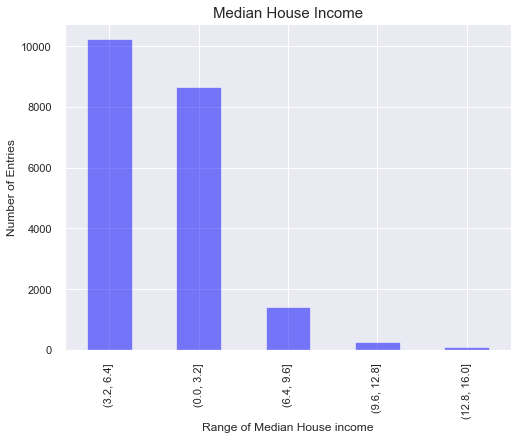

In [92]:
plt.figure(figsize=(8,6))
data['median_income_cats'].value_counts().plot(kind='bar', color='blue' , alpha=.5)
# plt.plot(kind='bar', color='b', alpha=.5)
plt.title("Median House Income", fontsize= 15)
plt.xlabel("Range of Median House income")
plt.ylabel("Number of Entries")
plt.show()

# Proportion or percentage of each bucket as per median house income

In [91]:
data["median_income_cats"].value_counts()/len(data)

(3.2, 6.4]      0.495736
(0.0, 3.2]      0.419525
(6.4, 9.6]      0.068169
(9.6, 12.8]     0.012403
(12.8, 16.0]    0.004167
Name: median_income_cats, dtype: float64

In [93]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,median_income_cats
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,6.984127,0.146591,2.555556,"(6.4, 9.6]"
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,6.238137,0.155797,2.109842,"(6.4, 9.6]"
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,8.288136,0.129516,2.802260,"(6.4, 9.6]"
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,5.817352,0.184458,2.547945,"(3.2, 6.4]"
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,6.281853,0.172096,2.181467,"(3.2, 6.4]"


# Making a copy of the data

In [94]:
data2 = data[:]

# Train Test Split

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data, test_size=0.2, stratify=data["median_income_cats"]
                                  , shuffle=True, random_state=144)

In [96]:
X_train["median_income_cats"].value_counts()/len(X_train)

(3.2, 6.4]      0.495761
(0.0, 3.2]      0.419513
(6.4, 9.6]      0.068132
(9.6, 12.8]     0.012415
(12.8, 16.0]    0.004179
Name: median_income_cats, dtype: float64

In [97]:
X_test["median_income_cats"].value_counts()/len(X_test)

(3.2, 6.4]      0.495640
(0.0, 3.2]      0.419574
(6.4, 9.6]      0.068314
(9.6, 12.8]     0.012355
(12.8, 16.0]    0.004118
Name: median_income_cats, dtype: float64

# Creating a validation for further analysis

In [98]:
X_train ,X_valid = train_test_split(X_train,test_size=0.15,stratify = X_train["median_income_cats"],
                                   shuffle=True, random_state=144)


# creating the label vectors. Note : I made it this way so its easy for you to understand the steps involved.


In [99]:
y_train = X_train["median_house_value"].copy()
y_valid = X_valid["median_house_value"].copy()
y_test = X_test["median_house_value"].copy()

In [100]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(14035, 14)
(4128, 14)
(2477, 14)
(14035,)
(4128,)
(2477,)


# Dropping the target variable

In [101]:
X_train.drop("median_house_value", axis=1,inplace=True)
X_valid.drop("median_house_value", axis=1,inplace=True)
X_test.drop("median_house_value", axis=1,inplace=True)

# Dropping the extra column i created too as we dont need it anymore as we just needed it for the stratification.

In [102]:
X_train.drop("median_income_cats", axis=1,inplace=True)
X_valid.drop("median_income_cats", axis=1,inplace=True)
X_test.drop("median_income_cats", axis=1,inplace=True)

# Feature Scaling and Evaluating the models

## Regression Evaluation Metrics


Here are three common evaluation metrics for regression problems. All of these are **loss functions**, because we want to minimize them.<br>

*Consider, ${y}$ is a vector of `n` predictions generated from a sample of `n` data points on all variables, and 
$\hat{y}$ is the vector of observed values (target values) of the variable being predicted.<br>*

**[Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error)** (MAE) is the mean of the absolute value of the errors: <br>
it's the average error!

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i  |$$

**[Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)** (MSE) is the mean of the squared errors:<br>
**MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**[Root Mean Squared Error](https://en.wikipedia.org/wiki/Root-mean-square_deviation)** (RMSE) is the square root of the mean of the squared errors:<br>
**RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units. <br><br>The root-mean-squared error (**RMSE**) **or** root-mean-square deviation (**RMSD**), is a frequently used measure of the differences between values predicted by a model or an estimator and the values actually observed. The RMSD represents the sample standard deviation of the differences between predicted values and observed values.


### $R^2$ statistics

The R-squared statistic provides a measure of fit. It takes the form of a proportion—the proportion of variance
explained—and so it always takes on a value between 0 and 1. 
In simple words, it represents how much of our data is being explained by our model. 
For example,  $R^2$ statistic = 0.75, it says that our model fits 75 % of the total data set.
Similarly, if it is 0, it means none of the data points is being explained and a value of 1 represents 100% data explanation.
Mathematically $R^2$ statistic is calculated as :
<img src="RSquared.PNG" width="300">
                                              
Where RSS:  is  the Residual Sum of squares and is given as :
<img src="RSS.PNG">
                                                                
RSS is the residual(error) term we have been talking about so far.
And, TSS:  is  the Total sum of squares and given as :
<img src="TSS.PNG">
                                                             
TSS is calculated when we consider the line passing through the mean value of y, to be the best fit line.
Just like RSS, we calculate the error term when the best fit line is the line passing through the mean value of y and we get the value of TSS.
    <img src="TSS2.PNG">
    
The closer the value of R2 is to 1 the better the model fits our data. If R2 comes below 0(which is a possibility) that means the model is so bad that it is performing even worse than the average best fit line.



$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$
<br><br><br>
Let's calculate MAE, MSE and RMSE for our model. <br>We need to pass the y_test and predictions to the respective method!<br>

We need to do another import here!